# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be `implementing decision tree for the regression by hand.`

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """

    if y.size == 0:
        return 0
    return np.mean(np.abs(y - np.mean(y)))

To calculate the impurity criterion for a regression decision tree using the mean absolute deviation (MAD) we can use NumPy's vectorized operations

Formula: $$MAD = \frac{1}{n} \sum_{i=1}^{n} |y_i - \bar{y}|$$

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    if y.size == 0:
        return 0

    # Predicate for splitting data based on feature j and threshold t
    predicate = X[:, j] <= t

    # Split data into left and right nodes
    y_l = y[predicate]
    y_r = y[~predicate]

    # Calculate value of the cost function
    return ((len(y_l) / len(y)) * H(y_l)) + ((len(y_r) / len(y)) * H(y_r))

This implementation first determines which samples belong to the left and right nodes based on whether their feature value `X[:, j]` is less than or equal to the threshold `t`.
It then calculates the impurity of each node using the previously defined `function H` and returns the final cost function value.


### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf



    """
    To implement the best_split method, we will iterate over all features and all possible thresholds to find the split that minimizes the cost function Q.
    And since the min_samples_leaf parameter imposes a restriction on the minimum number of samples in a leaf,
      we need to make sure that both left and right child nodes have at least min_samples_leaf samples after the split.
    """
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """

        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)

        X_left = y_left = X_right = y_right = None

        # Try all features
        for j in range(X.shape[1]):
            # Get all unique thresholds for feature j
            thresholds = np.unique(X[:, j])
            for t in thresholds:
                # Split data based on the threshold
                predicate = X[:, j] <= t
                y_l, y_r = y[predicate], y[~predicate]

                if len(y_l) < self.min_samples_leaf or len(y_r) < self.min_samples_leaf:
                    continue  # Skip the current threshold as it doesn't satisfy the min_samples_leaf condition

                cost = Q(X, y, j, t)
                if cost < best_cost:
                    best_cost = cost
                    best_split_column = j
                    best_threshold = t

                    X_left, y_left = X[predicate], y_l
                    X_right, y_right = X[~predicate], y_r

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal =True
            node.prediction = np.mean(y)  # Calculate and store the mean value as the prediction.
            return

        # Find best split
        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)


        # If no valid split, declare the node as terminal
        if split_column is None:
            node.is_terminal = True
            node.prediction = np.mean(y)  # Calculate and store the mean value as the prediction.
            return

        # Set node details
        node.column = split_column
        node.threshold = threshold
        node.prediction = np.mean(y)  # The prediction for the current node (mean value)

        # Create child nodes and set details for them
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)  # The prediction for the current node (mean value)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)  # The prediction for the current node (mean value)

        # Grow left and right children
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)



    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        # Initialize the tree (root node)
        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)

        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """

        # Check if the current node is a terminal node
        if node.is_terminal:
            return node.prediction

        # Traverse subtree according to the splitting condition for the current node
        return self.get_prediction(node.left if x[node.column] <= node.threshold else node.right, x)

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [28]:
from sklearn.datasets import fetch_openml
# Load Boston housing dataset from OpenML
boston = fetch_openml(name='boston', version=1, as_frame=False, parser='auto')
X, y = boston.data, boston.target

In [29]:
from sklearn.model_selection import train_test_split

# Split the dataset into 75% train and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
for depth in [1, 3, 5]:
    # Initialize and fit the regressor
    reg = MyDecisionTreeRegressor(max_depth=depth)
    reg.fit(X_train, y_train)

ValueError: ignored

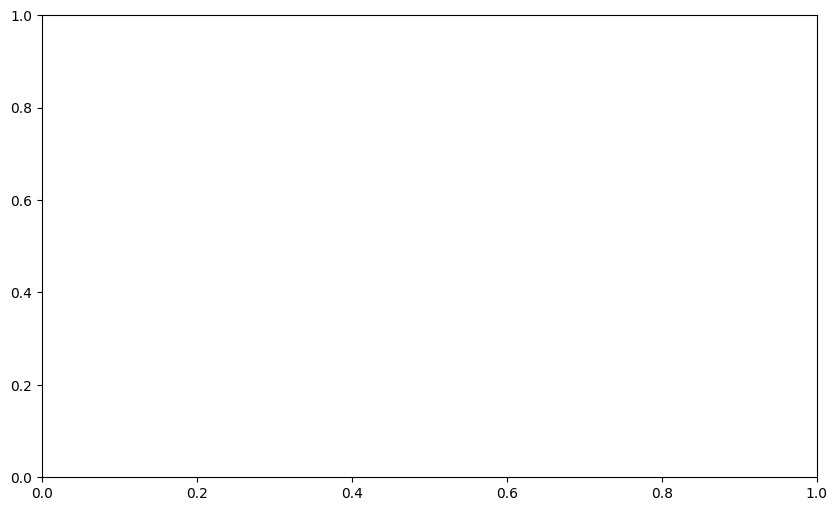

In [ ]:
# Specify the depths for which we want to fit trees
tree_depths = [1, 3, 5]

# Iterate and process for each tree depth
for depth in tree_depths:
    # Initialize and fit the regressor
    reg = MyDecisionTreeRegressor(max_depth=depth)
    reg.fit(X_train, y_train)


    # Get the index of the feature used for splitting in the root node
    root_node_feature_index = reg.tree_.column  # Assuming the root is named 'tree_' and the feature index is 'column'

    # Scatter plot for the selected feature against the target variable
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train[:, root_node_feature_index], y_train, color='blue', label='Training points')
    plt.xlabel(boston.feature_names[root_node_feature_index])
    plt.ylabel('Target')
    plt.title(f'Train Data and Decision Tree Split for Depth = {depth}')
    plt.legend()
    plt.show()

    # MAE on train and test data
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"Depth: {depth}, Train MAE: {mae_train:.3f}, Test MAE: {mae_test:.3f}")

    if mae_train < mae_test:
        print("Possible overfitting.\n")
    else:
        print("No overfitting detected.\n")


### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [ ]:
# YOUR CODE HERE

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [30]:
from sklearn.utils import resample


def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in
    Returns
    -------
    bias2 : float,
        Estiamted squared bias
    variance : float,
        Estiamted variance
    """

    # YOUR CODE HERE

    n_samples = x.shape[0]
    predictions = np.zeros((n_samples, n_iter)) * np.nan  # Initialize with NaN

    for i in range(n_iter):
        # Bootstrap sample and corresponding OOB indices
        X_i, y_i = resample(x, y)
        bootstrap_indices = np.array([np.where((x == X_i[j]).all(axis=1))[0][0] for j in range(X_i.shape[0])])
        oob_indices = np.setdiff1d(np.arange(n_samples), bootstrap_indices)

        # Fit model on X_i and predict on OOB samples
        estimator.fit(X_i, y_i)
        predictions[oob_indices, i] = estimator.predict(x[oob_indices])

    # Mask to identify valid predictions (not NaN)
    msk = ~np.isnan(predictions)

    # Compute average prediction across all algorithms/models for each sample
    # Only consider the cases where there was at least one prediction (msk is True)
    avg_prediction = np.nan_to_num(predictions.sum(axis=1) / msk.sum(axis=1))

    # Calculate squared bias per sample
    # And then take the average across all samples
    squared_bias_per_sample = (avg_prediction - y) ** 2
    bias2 = squared_bias_per_sample[msk.any(axis=1)].mean()

    # Calculate variance per sample
    # And then take the average across all samples
    variance = np.nan_to_num(predictions - avg_prediction[:, None]) ** 2
    variance = variance[msk].mean()

    return bias2, variance


In [31]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(610.8195454545455, 608.8465409460055)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

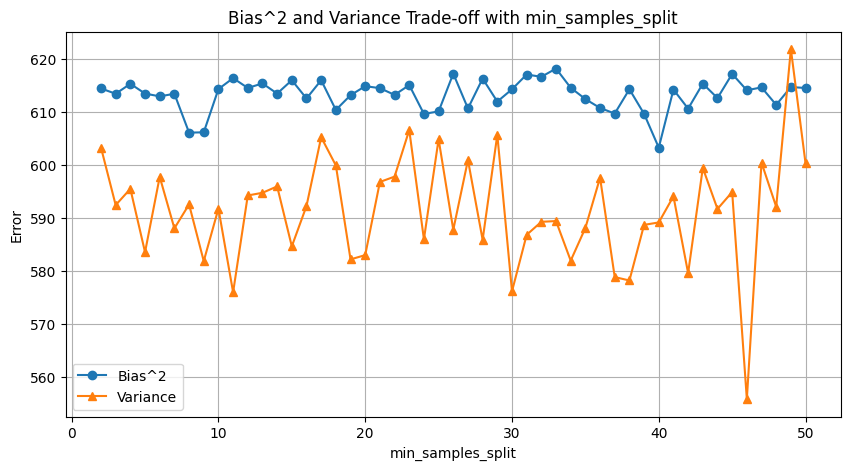

In [33]:
# Define the range of min_samples_split values to test
min_samples_splits = range(2, 51)  # From 2 up to 50

# Lists to store the results
biases = []
variances = []

# Compute bias and variance for different values of min_samples_split
for min_samples_split in min_samples_splits:
    estimator = MyDecisionTreeRegressor(min_samples_split=min_samples_split)
    bias2, variance = get_bias_variance(estimator, X_train, y_train, n_iter=10)
    biases.append(bias2)
    variances.append(variance)

# Plotting bias^2 and variance
plt.figure(figsize=(10, 5))
plt.plot(min_samples_splits, biases, label='Bias^2', marker='o')
plt.plot(min_samples_splits, variances, label='Variance', marker='^')
plt.xlabel('min_samples_split')
plt.ylabel('Error')
plt.title('Bias^2 and Variance Trade-off with min_samples_split')
plt.legend()
plt.grid(True)
plt.show()

``` your comments here```

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [35]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingRegressor

tree_estimator = MyDecisionTreeRegressor(min_samples_split=15)
tree_bias2, tree_variance = get_bias_variance(tree_estimator, X_train, y_train, n_iter=10)

# Bagging ensemble of decision trees
bagging_estimator = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(min_samples_split=15), n_estimators=10)
bagging_bias2, bagging_variance = get_bias_variance(bagging_estimator, X_train, y_train, n_iter=10)

# Compare and discuss results
print(f"Individual Tree - Bias^2: {tree_bias2}, Variance: {tree_variance}")
print(f"Bagging Ensemble - Bias^2: {bagging_bias2}, Variance: {bagging_variance}")

Individual Tree - Bias^2: 613.454327176781, Variance: 590.0489749084354
Bagging Ensemble - Bias^2: 611.0925066666666, Variance: 585.5800743963192


```your comments here```

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task.

In [67]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [68]:
# Drop unnecessery columns - names are not important, and birth date can be replaced by age
X = X.drop(['lastName', 'firstName', 'personName', 'birthDate', 'birthYear', 'birthMonth', 'birthDay'], axis=1)

# 0. Drop columns with a high percentage of missing values
threshold = 0.5 # Example threshold
cols_with_missing = [col for col in X.columns if X[col].isnull().mean() > threshold]
X = X.drop(cols_with_missing, axis=1)

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# 1. Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Separate the columns by type
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Define the transformations
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),  # or another strategy for imputation
    OneHotEncoder(handle_unknown='ignore')     # to encode categorical variables
)

numerical_transformer = SimpleImputer(strategy='mean')  # or another strategy for imputation

# Create the preprocessor with ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # This will let any other column pass through without changes
)

# Example usage on the train dataset -- you can apply the same transformer to the test dataset when needed
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

In [ ]:
# YOUR CODE HERE